In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import cv2
from ipywidgets import IntProgress
from tqdm import tqdm
from PIL import Image

from dataset import FootballFrameDataset
from models import *#train_model, set_parameter_requires_grad, initialize_model

In [2]:
train = pd.read_csv('data/train.csv', index_col=[0])
val = pd.read_csv('data/val.csv', index_col=[0])
mapper = {"neg": 0, "pos": 1}

In [3]:
model_name = "inception"
num_classes = 2
batch_size = 30
num_epochs = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data augmentation

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        torchvision.transforms.RandomGrayscale(p=0.2),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
    ])
}

In [5]:
train_data = FootballFrameDataset(train, transforms=data_transforms['train'], normalize=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)

val_data = FootballFrameDataset(val, transforms=None, normalize=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=0)

# Building two Inceptionv3 networks
1. pretrained (On ImageNet) with feature extraction + only retraining the last dense layer
2. training the entire network from scratch 

In [7]:
# Send the model to GPU
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

loading inception
Params to learn:
	 AuxLogits.fc.weight
	 AuxLogits.fc.bias
	 fc.weight
	 fc.bias


# Training

#### using a pretrained model

In [10]:
feature_extract = True
criterion = nn.CrossEntropyLoss()
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

#### training from scratch

In [11]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# comparing the two models

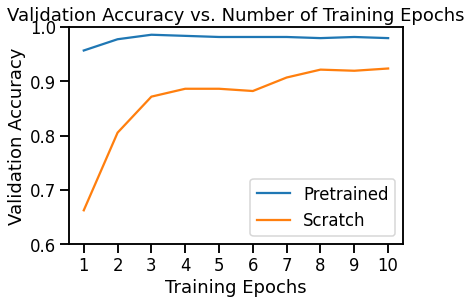

In [35]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0.6,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

##### save models

In [ ]:
torch.save(scratch_model.state_dict(), 'models/Scratch_CP_epoch_{}.pth'.format(num_epochs + 1))
torch.save(model_ft.state_dict(), 'models/Pretrained_CP_epoch_{}.pth'.format(num_epochs + 1))

-------

# Evaluation

In [21]:
from eval import *

# test set 
### created in the train/val/test split which inlcudes data from two matches

In [7]:
# step 1: load the models

In [8]:
pretrained, _ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
pretrained = load_trained_model(pretrained, model_path = 'models/Pretrained_CP_epoch_11.pth', device=device)

loading inception
[*] Loaded weights from models/Pretrained_CP_epoch_11.pth


In [9]:
scratch, _ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch = load_trained_model(scratch, model_path = 'models/Scratch_CP_epoch_11.pth', device=device)

loading inception
[*] Loaded weights from models/Scratch_CP_epoch_11.pth


In [10]:
# load test data

test = pd.read_csv('data/test.csv', index_col=[0])
test_data = FootballFrameDataset(test, transforms=None, normalize=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle=True, num_workers=0)

100%|██████████| 10/10 [00:39<00:00,  3.90s/it]


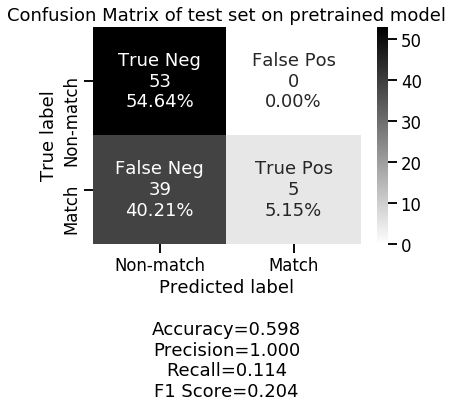

In [11]:
pretrained_stats = Evaluater(net = pretrained,
                             data_loader = test_loader,
                             categories = ['Non-match' ,'Match'], 
                             model_name = 'pretrained',
                             device=device)
pretrained_stats.eval_trained_model()
pretrained_stats.confustion_matrix()

100%|██████████| 10/10 [00:37<00:00,  3.79s/it]


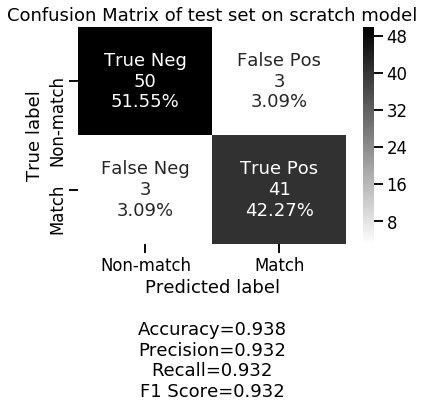

In [13]:
scratch_stats = Evaluater(net = scratch,
                             data_loader = test_loader,
                             categories = ['Non-match' ,'Match'], 
                             model_name = 'scratch',
                             device=device)
scratch_stats.eval_trained_model()
scratch_stats.confustion_matrix()

# evaluation on secret test set plus result saving

In [22]:
secret_path = "data/FrameFilter-test_set"
batch_size = 10

In [26]:
result_pretrained = eval_model_test_set(model = pretrained,
                                        test_path = secret_path,
                                        batch_size = batch_size,
                                        device=device)

298it [01:17,  6.54it/s]

KeyboardInterrupt: 

In [ ]:
result_scratch = eval_model_test_set(model = scratch,
                                     test_path = secret_path,
                                     batch_size = batch_size,
                                     device=device)

In [223]:
result_pretrained.to_csv("using_pretrained.csv")

0.030614599585533142

In [225]:
result_scratch.to_csv("from_scratch.csv")

0.9998728036880493